In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn import tree

In [109]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

# 按原始分群定義分群

In [110]:
df = pd.read_csv("D:/NCTU/12-資料產出/NCTU/alert處理new3.csv")

In [111]:
def Segmentation(TYPE, score):
    if TYPE == 'original':
        riskHigh = df[df['Cust_Segmentation']=='PH']
        riskLow = df[df['Cust_Segmentation']=='PNH']
    elif TYPE =='selfDefined':
        riskHigh = df[df['risk_score'] >= score]
        riskLow = df[df['risk_score'] < score]
    
    return riskHigh, riskLow

In [112]:
def printResult(y_pred, test_label):
    '''
    prediction on test dataset
    '''
    acc = accuracy_score(test_label,  y_pred.round().astype(int))
    f1 = f1_score(test_label, y_pred.round().astype(int))
    r = recall_score(test_label,  y_pred.round().astype(int))
    p = precision_score(test_label,  y_pred.round().astype(int))
    recall, precision, thresholds = precision_recall_curve(test_label,  y_pred)
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)): 
        if test_label[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and test_label[i]==0: 
            FP += 1
        if test_label[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and test_label[i]==1:
            FN += 1

    HRS = (TN+FN)/(TN+FN+TP+FP)
    
    print('acc: ', acc, 'f1: ',f1,'recall: ', r, 'precision: ', p, 'filter rate: ', HRS)
    print('TP: ', TP, 'FP: ', FP, 'FN: ', FN, 'TN: ', TN)

In [113]:
TYPE = 'original'
score = 0
riskHigh, riskLow = Segmentation(TYPE, score)

### risk score切分落在124左右(original)

In [114]:
riskHighID = riskHigh['alert_id'].values

In [115]:
riskHighID = riskHigh['alert_id'].values

# 分群閥值

In [116]:
%run function.ipynb

In [117]:
SAR_type = 'TO_SAR'

## TWN_A11_01

In [118]:
DAY = 15
FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv"

In [119]:
file = pd.read_csv(PATH+FILE)

In [120]:
file.shape

(86770, 45)

In [121]:
file['TO_SAR'] = file['TO_SAR'].replace(np.nan, 0)
file['TO_SAR'] = file['TO_SAR'].replace('NF', 1)
file['TO_SAR'] = file['TO_SAR'].replace('F', 1)

In [122]:
fileID = file['alert_id'].values

In [123]:
HighIntersection = list(set(fileID) & set(riskHighID))

In [124]:
rowHigh = []
rowLow = []
for i in range(file.shape[0]):
    if file['alert_id'][i] in HighIntersection:
        rowHigh.append(i)
    else:
        rowLow.append(i)

In [125]:
file1 = file.iloc[rowHigh] 

In [126]:
train_set, test_set = ReadFile(file1, SAR_type)

Verify on time series
shape of data: (75, 39)
total number of TO_SAR: 0
********************************
time interval in train set:2019-12-11~2020-01-03
TO_SAR in train set: 0
TO_SAR/Total in train set 0.0
split dataset to train, test...
********************************
time interval in test set:2020-01-03~2020-01-30
TO_SAR in test set: 0
TO_SAR/Total in test set 0.0
********************************
train data shape:  (45, 38)
test data shape:  (30, 38)


In [127]:
file2 = file.iloc[rowLow] 

In [128]:
train_set, test_set = ReadFile(file2, SAR_type)

Verify on time series
shape of data: (86695, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005133035988926484
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.005161625191037804
********************************
train data shape:  (52016, 38)
test data shape:  (34679, 38)


In [129]:
# duplication
ratio = train_set[train_set['TO_SAR']==0].shape[0] / train_set[train_set['TO_SAR']==1].shape[0]

In [130]:
train_set = train_set.append([train_set[train_set['TO_SAR']==1]]*(int(ratio)-1))

In [131]:
train_set['TO_SAR'].value_counts()

0    51749
1    51531
Name: TO_SAR, dtype: int64

In [132]:
col = [*FEATURE, 'TO_SAR']
train_set = train_set[col]
test_set = test_set[col]

In [133]:
print(train_set.shape)
train_set = train_set.dropna()
print(train_set.shape)

(103280, 5)
(103279, 5)


In [134]:
X_train = train_set.drop(['TO_SAR'], axis = 1)
y_train = train_set['TO_SAR']

In [135]:
print(X_train.shape, y_train.shape)

(103279, 4) (103279,)


In [136]:
print(test_set.shape)
test_set = test_set.dropna()
print(test_set.shape)

(34679, 5)
(34679, 5)


In [137]:
X_test = test_set.drop(['TO_SAR'], axis = 1)
y_test = test_set['TO_SAR']

In [138]:
print(X_test.shape, y_test.shape)

(34679, 4) (34679,)


In [139]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

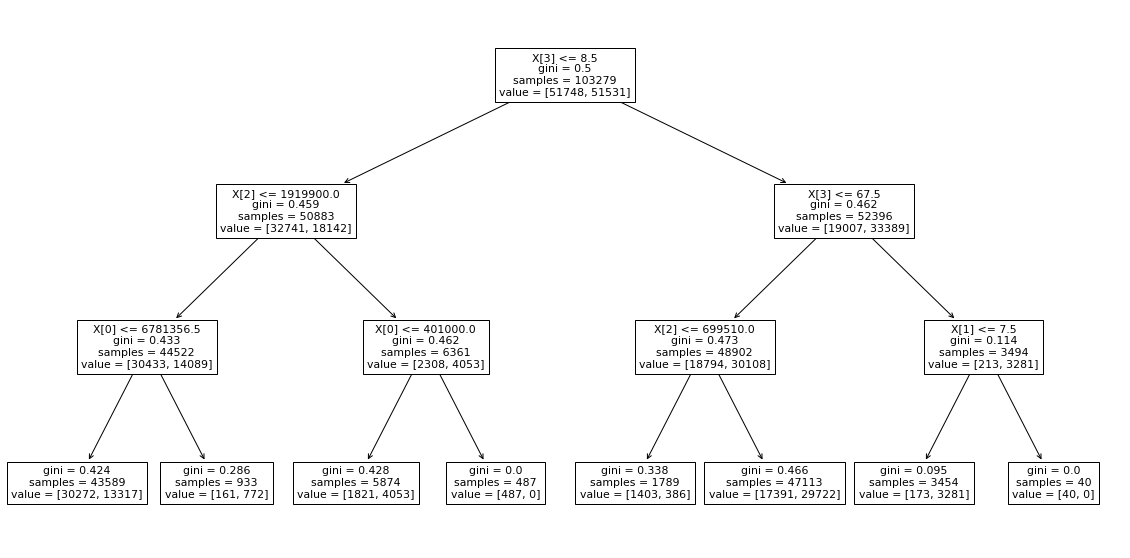

In [154]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf)
plt.savefig('tree.eps', format='eps', bbox_inches = "tight")

In [150]:
plt.savefig('D:/Temp/NCTU/crystal/第二階段/new_alert/閥值優化/chart/DecisionTreeA11_01.pdf')

<Figure size 432x288 with 0 Axes>

In [33]:
13317+772+4053+0+386+29722+3281+0

51531

In [34]:
43589+933+5874+487+1789+47113+3454+40

103279

In [35]:
y_pred = clf.predict(X_test)

In [36]:
printResult(y_pred, y_test)

acc:  0.6127339311975547 f1:  0.01942172897196262 recall:  0.7430167597765364 precision:  0.00983946141895391 filter rate:  0.6102252083393408
TP:  133 FP:  13384 FN:  46 TN:  21116


In [40]:
tree_to_code(clf, X_train.columns)

def tree(Credit_Amt, number_of_Credit, Debit_Amt, number_of_Debit):
  if number_of_Debit <= 8.5:
    if Debit_Amt <= 1919900.0:
      if Credit_Amt <= 6781356.5:
        return [[30272. 13317.]]
      else:  # if Credit_Amt > 6781356.5
        return [[161. 772.]]
    else:  # if Debit_Amt > 1919900.0
      if Credit_Amt <= 401000.0:
        return [[1821. 4053.]]
      else:  # if Credit_Amt > 401000.0
        return [[487.   0.]]
  else:  # if number_of_Debit > 8.5
    if number_of_Debit <= 67.5:
      if Debit_Amt <= 699510.0:
        return [[1403.  386.]]
      else:  # if Debit_Amt > 699510.0
        return [[17391. 29722.]]
    else:  # if number_of_Debit > 67.5
      if number_of_Credit <= 7.5:
        return [[ 173. 3281.]]
      else:  # if number_of_Credit > 7.5
        return [[40.  0.]]


## TWN_A12_01

In [42]:
DAY = 15
FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A12_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv"

In [43]:
file = pd.read_csv(PATH+FILE)

C:\Users\NCTUUser2\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [44]:
file['TO_SAR'] = file['TO_SAR'].replace(np.nan, 0)
file['TO_SAR'] = file['TO_SAR'].replace('NF', 1)
file['TO_SAR'] = file['TO_SAR'].replace('F', 1)

In [45]:
fileID = file['alert_id'].values

In [46]:
HighIntersection = list(set(fileID) & set(riskHighID))

In [47]:
rowHigh = []
rowLow = []
for i in range(file.shape[0]):
    if file['alert_id'][i] in HighIntersection:
        rowHigh.append(i)
    else:
        rowLow.append(i)

In [48]:
file1 = file.iloc[rowHigh] 

In [49]:
train_set, test_set = ReadFile(file1, SAR_type)

Verify on time series
shape of data: (77, 39)
total number of TO_SAR: 0
********************************
time interval in train set:2019-12-11~2020-01-03
TO_SAR in train set: 0
TO_SAR/Total in train set 0.0
split dataset to train, test...
********************************
time interval in test set:2020-01-06~2020-11-27
TO_SAR in test set: 0
TO_SAR/Total in test set 0.0
********************************
train data shape:  (46, 38)
test data shape:  (31, 38)


In [50]:
file2 = file.iloc[rowLow] 

In [51]:
train_set, test_set = ReadFile(file2, SAR_type)

Verify on time series
shape of data: (49888, 39)
total number of TO_SAR: 241
********************************
time interval in train set:2019-03-04~2020-05-21
TO_SAR in train set: 144
TO_SAR/Total in train set 0.004810904717359348
split dataset to train, test...
********************************
time interval in test set:2020-02-20~2020-12-31
TO_SAR in test set: 97
TO_SAR/Total in test set 0.004860693525756665
********************************
train data shape:  (29932, 38)
test data shape:  (19956, 38)


In [52]:
# duplication
ratio = train_set[train_set['TO_SAR']==0].shape[0] / train_set[train_set['TO_SAR']==1].shape[0]

In [53]:
train_set = train_set.append([train_set[train_set['TO_SAR']==1]]*(int(ratio)-1))

In [54]:
col = [*FEATURE, 'TO_SAR']
train_set = train_set[col]
test_set = test_set[col]

In [55]:
print(train_set.shape)
train_set = train_set.dropna()
print(train_set.shape)

(59452, 5)
(59451, 5)


In [56]:
X_train = train_set.drop(['TO_SAR'], axis = 1)
y_train = train_set['TO_SAR']

In [57]:
print(test_set.shape)
test_set = test_set.dropna()
print(test_set.shape)

(19956, 5)
(19956, 5)


In [58]:
X_test = test_set.drop(['TO_SAR'], axis = 1)
y_test = test_set['TO_SAR']

In [59]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

[]

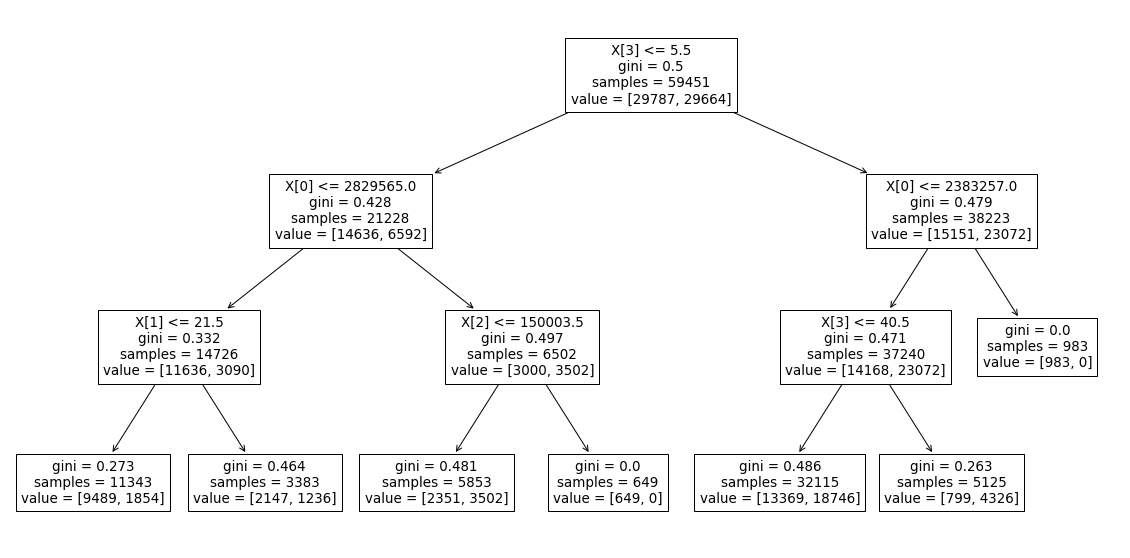

In [60]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf)
plt.plot()

In [61]:
y_pred = clf.predict(X_test)
printResult(y_pred, y_test)

acc:  0.468129885748647 f1:  0.014484679665738161 recall:  0.8041237113402062 precision:  0.007308160779537149 filter rate:  0.46517338143916614
TP:  78 FP:  10595 FN:  19 TN:  9264


In [64]:
tree_to_code(clf, X_train.columns)

def tree(Credit_Amt, number_of_Credit, Debit_Amt, number_of_Debit):
  if number_of_Debit <= 5.5:
    if Credit_Amt <= 2829565.0:
      if number_of_Credit <= 21.5:
        return [[9489. 1854.]]
      else:  # if number_of_Credit > 21.5
        return [[2147. 1236.]]
    else:  # if Credit_Amt > 2829565.0
      if Debit_Amt <= 150003.5:
        return [[2351. 3502.]]
      else:  # if Debit_Amt > 150003.5
        return [[649.   0.]]
  else:  # if number_of_Debit > 5.5
    if Credit_Amt <= 2383257.0:
      if number_of_Debit <= 40.5:
        return [[13369. 18746.]]
      else:  # if number_of_Debit > 40.5
        return [[ 799. 4326.]]
    else:  # if Credit_Amt > 2383257.0
      return [[983.   0.]]
